# Initialize Notebook

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl

%jsroot on
# %matplotlib qt
%matplotlib inline

In [3]:
from filterMethods import *
from reconstructionMethods import *
from statisticsMethods import *

In [4]:
sys.path.append("../")
import plotParameters

In [5]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [6]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../runs/calibration_8x8x8_e-_5MeV/calibration.root'
file_input_name = '../build/output.root'
# file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

histogram_wall = [title.split('_')[1] for title in histogram_titles]
print(histogram_wall)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [7]:
tree = file_input_uproot['photoSensor_hits;1']

position_relative_x = tree['photoSensor_hits_position_relative_x'].array()
position_relative_y = tree['photoSensor_hits_position_relative_y'].array()

histogram = file_input_pyroot.Get(histogram_names[0])
n_bins_x = histogram.GetNbinsX()
n_bins_y = histogram.GetNbinsY()
values = np.zeros((n_bins_x, n_bins_y))
x_edges = []
y_edges = []
for i in range(1, n_bins_x + 2):
    x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
for i in range(1, n_bins_y + 2):
    y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))
x_edges[ 0] -= 1e-9
y_edges[ 0] -= 1e-9
x_edges[-1] += 1e-9
y_edges[-1] += 1e-9

position_relative_x_bins = pd.Series(pd.cut(np.array(position_relative_x), bins=x_edges, retbins=False))
position_relative_y_bins = pd.Series(pd.cut(np.array(position_relative_y), bins=y_edges, retbins=False))
position_relative_x_binned = position_relative_x_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_y_binned = position_relative_y_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_x_nBin = position_relative_x_bins.cat.codes
position_relative_y_nBin = position_relative_y_bins.cat.codes

position_initial_x = tree['photoSensor_hits_position_initial_x'].array()
position_initial_y = tree['photoSensor_hits_position_initial_y'].array()
position_initial_z = tree['photoSensor_hits_position_initial_z'].array()

time = tree['photoSensor_hits_time'].array()
photoSensorID = tree['photoSensor_hits_photoSensorID'].array()
photoSensorPosition = [(float(ID.split('_')[2]), float(ID.split('_')[3]), float(ID.split('_')[4])) for ID in photoSensorID]
photoSensorWall = [ID.split('_')[1] for ID in photoSensorID]
photoSensorDirection = []
for wall in photoSensorWall:
    if wall == '+x':
        photoSensorDirection.append([-1, 0, 0])
    elif wall == '-x':
        photoSensorDirection.append([+1, 0, 0])
    elif wall == '+y':
        photoSensorDirection.append([0, -1, 0])
    elif wall == '-y':
        photoSensorDirection.append([0, +1, 0])
    elif wall == '+z':
        photoSensorDirection.append([0, 0, -1])
    elif wall == '-z':
        photoSensorDirection.append([0, 0, +1])

df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'] = photoSensorID
df_hits['sensor_direction'] = photoSensorDirection
df_hits['sensor_position'] = photoSensorPosition
df_hits['relativePosition'] = list(zip(position_relative_x, position_relative_y))
df_hits['relativePosition_binned'] = list(zip(position_relative_x_binned, position_relative_y_binned))
df_hits['relativePosition_nBin'] = list(zip(position_relative_x_nBin, position_relative_y_nBin))
df_hits['initialPosition'] = list(zip(position_initial_x, position_initial_y, position_initial_z))
df_hits['time'] = time

# print(df_hits)

In [8]:
primary_tree = file_input_uproot['primary;1']
position_x = primary_tree['primary_position_x'].array()
position_y = primary_tree['primary_position_y'].array()
position_z = primary_tree['primary_position_z'].array()
time = primary_tree['primary_time'].array()

df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = list(zip(position_x, position_y, position_z))
df_primary['time'] = time

# Constants

In [9]:
CM_PER_RAD = 34.14230382
MM_PER_CM = 10
CM_PER_M = 100
Y_LIM = 10 * MM_PER_CM
C_M = 299792458
C_CM = C_M * CM_PER_M
N_XENON = 1.84
C_XENON_M_PER_S = C_M / N_XENON
C_XENON_CM_PER_S = C_XENON_M_PER_S * CM_PER_M
C_XENON_MM_PER_S = C_XENON_CM_PER_S * MM_PER_CM
NS_PER_S = 1e9
C_XENON_MM_PER_NS = C_XENON_MM_PER_S / NS_PER_S

# Filter Hits

In [10]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Reconstruct Hit Angle

In [11]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

In [12]:
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)

100%|██████████| 47159/47159 [00:00<00:00, 71598.17it/s]


In [13]:
df_hits = make_reconstructedVector_direction(df_hits)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/1100277444.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


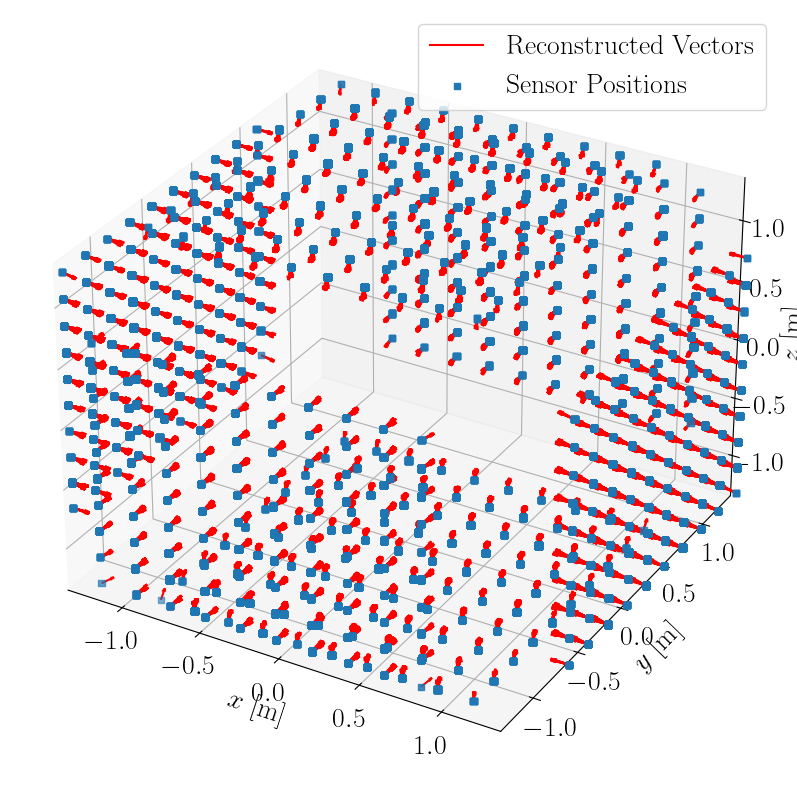

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
#            label='Reconstructed Points')
ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[2])/1000,
          df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
          label='Reconstructed Vectors',
          length=0.1,
          normalize=True,
          color='red')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend()
fig.show()

# Reconstruct Hit With Time

In [15]:
df_hits = make_reconstructedVector_time(df_hits, C_XENON_MM_PER_NS)

In [16]:
df_hits = make_reconstructedPoint_time(df_hits)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/1246560983.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


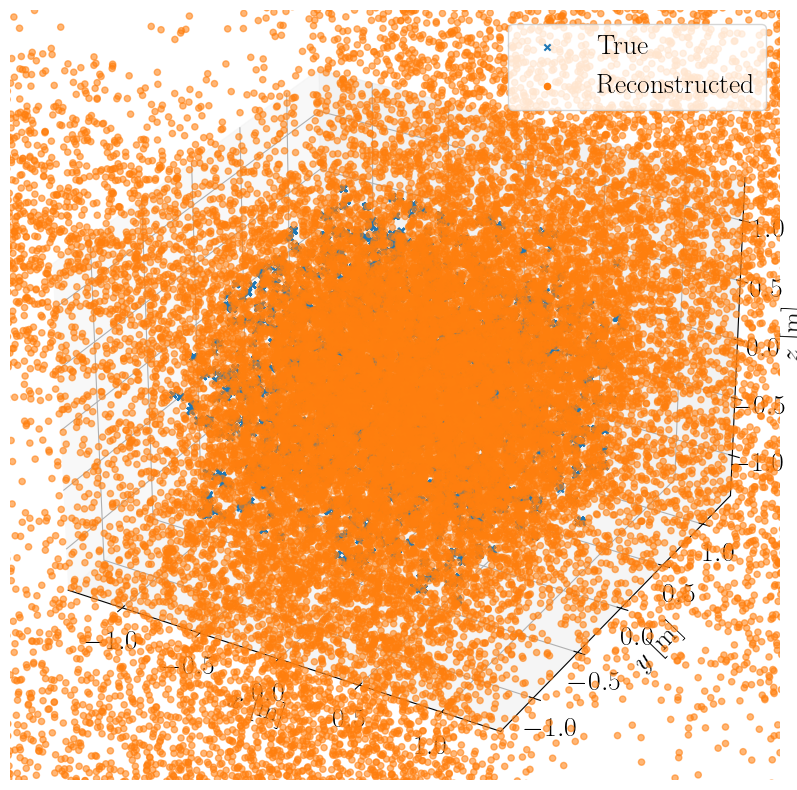

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

# Reconstruct Hit Ideally with Primary Position

In [18]:
df_hits = make_reconstructedPoint_primary_distance(df_hits, df_primary)

  0%|          | 0/47159 [00:00<?, ?it/s]

 38%|███▊      | 17836/47159 [06:16<10:19, 47.36it/s]


KeyboardInterrupt: 

In [ ]:
furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_primary_distance_r').index

print(df_hits.loc[furthestPoints]['reconstructedPoint_primary_distance_r'])

10027    1020
21033     851
22327     779
26726     763
10342     726
Name: reconstructedPoint_primary_distance_r, dtype: int64


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_48524/3053773788.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


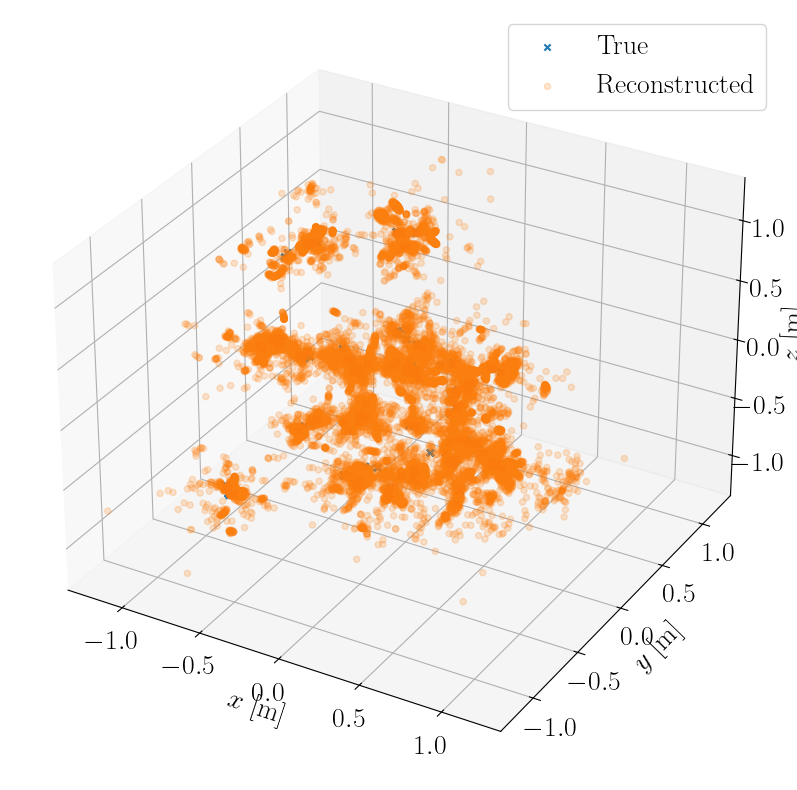

In [ ]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

mean = 76.84
std = 80.38
1 sigma = 81.60
2 sigma = 234.60
3 sigma = 448.80


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_48524/4277815851.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

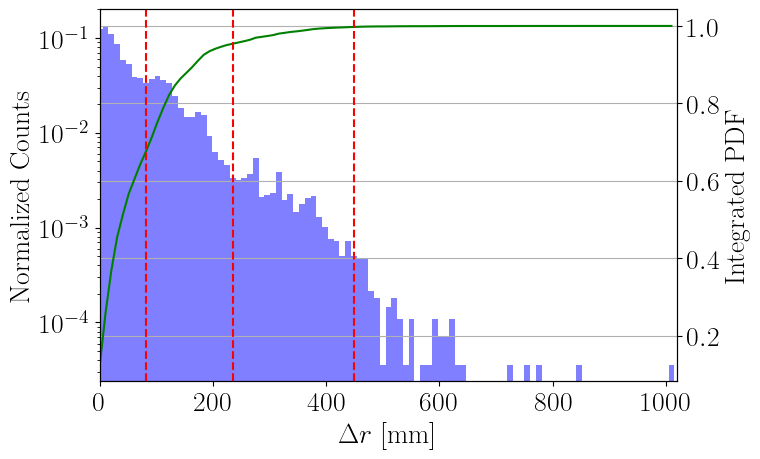

In [ ]:
PDF, hist, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_primary_distance_r'], nBins=100)
primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r'])
primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r'])
primary_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins)
primary_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins)
primary_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

print('mean = {:.2f}'.format(primary_mean))
print('std = {:.2f}'.format(primary_std))
print('1 sigma = {:.2f}'.format(primary_sigma_1))
print('2 sigma = {:.2f}'.format(primary_sigma_2))
print('3 sigma = {:.2f}'.format(primary_sigma_3))

ax2.axvline(primary_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(primary_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(primary_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [ ]:
df_hits['reconstructedPoint_primary_distance_r_x'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_primary_distance_r_y'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_primary_distance_r_z'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_48524/976198982.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

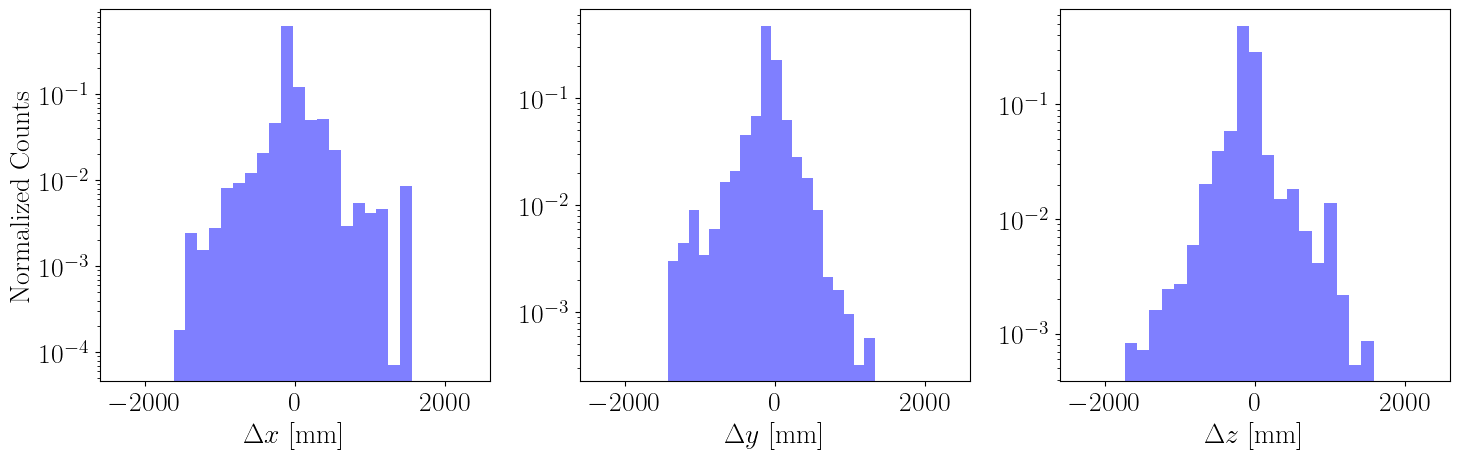

In [ ]:
nBins = 20

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_primary_distance_r_x'], nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_primary_distance_r_y'], nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_primary_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
fig.show()

# Reconstruct Hit Ideally with Initial Position

In [24]:
df_hits = make_reconstructedPoint_initial_distance(df_hits)

In [25]:
furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r').index
print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r'])

1946     1240.512446
43181    1192.631230
43521    1181.585436
40031    1168.506469
23491    1151.084417
Name: reconstructedPoint_initial_distance_r, dtype: float64


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/3488627808.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


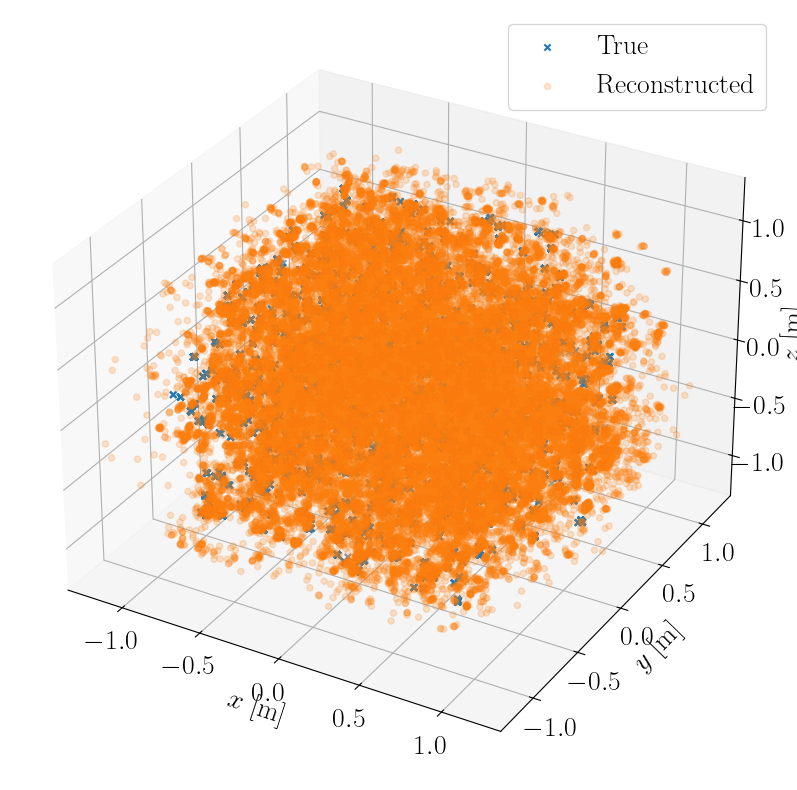

In [26]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_hits['initialPosition'].apply(lambda x: x[0])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[1])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

mean = 188.62
std = 151.00
1 sigma = 223.46
2 sigma = 459.12
3 sigma = 818.81


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/1427618381.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

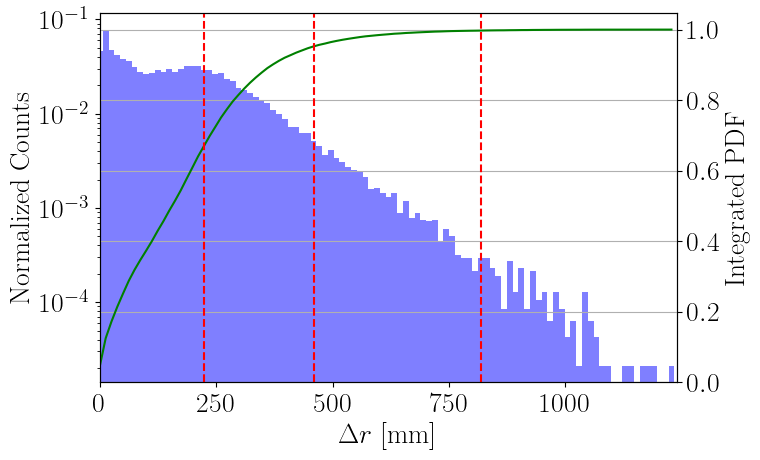

In [27]:
PDF, hist, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_initial_distance_r'], nBins=100)
initial_mean = np.mean(df_hits['reconstructedPoint_initial_distance_r'])
initial_std = np.std(df_hits['reconstructedPoint_initial_distance_r'])
initial_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins, nBins=bins)
initial_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins, nBins=bins)
initial_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins, nBins=bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

print('mean = {:.2f}'.format(initial_mean))
print('std = {:.2f}'.format(initial_std))
print('1 sigma = {:.2f}'.format(initial_sigma_1))
print('2 sigma = {:.2f}'.format(initial_sigma_2))
print('3 sigma = {:.2f}'.format(initial_sigma_3))

ax2.axvline(initial_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(initial_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(initial_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [28]:
df_hits['reconstructedPoint_initial_distance_r_x'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_initial_distance_r_y'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_initial_distance_r_z'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/1113289817.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

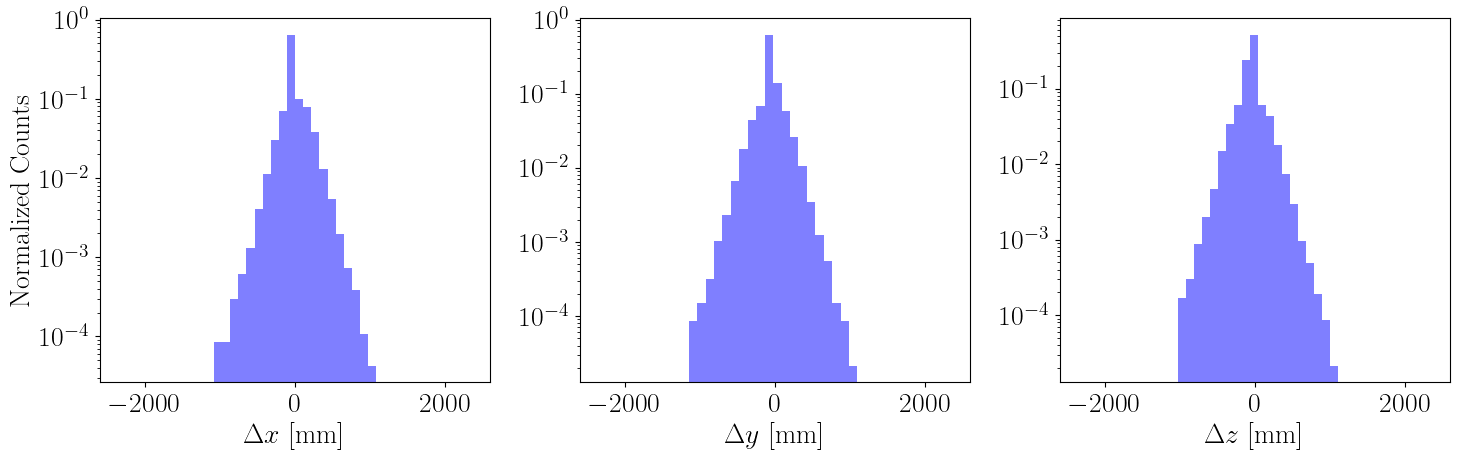

In [30]:
nBins = 20

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x'], nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y'], nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
fig.show()

In [31]:
df_hits = make_relativeVector(df_hits)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/2518781153.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


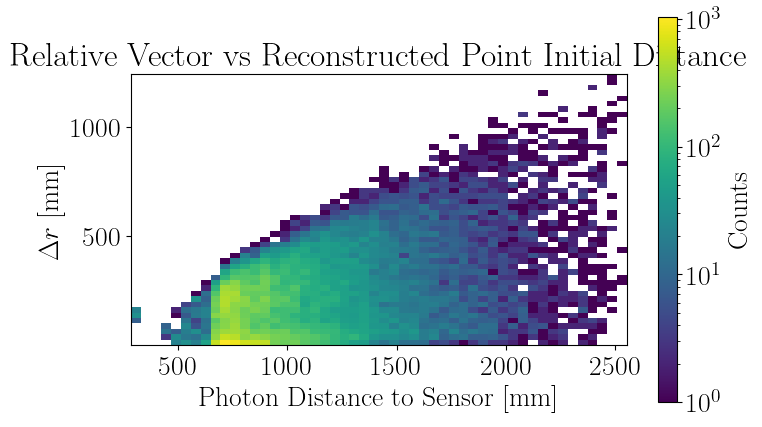

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

hist = ax.hist2d(df_hits['relativeVector_r'], df_hits['reconstructedPoint_initial_distance_r'], bins=50, norm=LogNorm())
ax.set_xlabel(r'Photon Distance to Sensor [mm]')
ax.set_ylabel(r'$\Delta r$ [mm]')
ax.set_aspect('equal')
ax.set_title('Relative Vector vs Reconstructed Point Initial Distance')

cbar = plt.colorbar(hist[3], ax=ax)
cbar.set_label('Counts')

fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/4176771212.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/4176771212.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


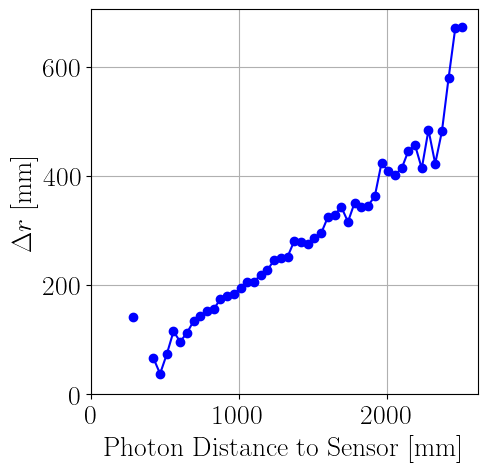

In [46]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fileName = '../figures/photonDistanceToSensor_vs_recoPointInitialDistance_60cm.pkl'
data = {
    'bins': bins,
    'average_recoPoint_r': average_recoPoint_r
}
with open(fileName, 'wb') as f:
    pkl.dump(data, f)

pkl_data = pkl.load(open(fileName, 'rb'))
bins = pkl_data['bins']
average_recoPoint_r = pkl_data['average_recoPoint_r']

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bins[:-1], average_recoPoint_r, marker='o', linestyle='-', color='b')
ax.set_xlabel(r'Photon Distance to Sensor [mm]')
ax.set_ylabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
# ax.set_aspect('equal')
ax.grid()
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/3877635709.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8609/3877635709.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


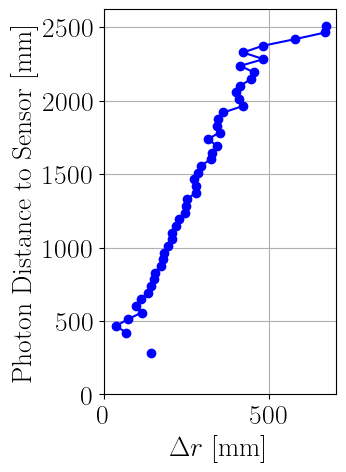

In [49]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fig, ax = plt.subplots(figsize=(3, 5))
ax.plot(average_recoPoint_r, bins[:-1], marker='o', linestyle='-', color='b')
ax.set_ylabel(r'Photon Distance to Sensor [mm]')
ax.set_xlabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.grid()

fig.show()

# Performance Reconstruction Methods With Respect to Filter Parameters

In [ ]:
print(search_radius)
print(search_number)
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(primary_sigma_1))
print('{:.2f}'.format(primary_sigma_2))
print('{:.2f}'.format(primary_sigma_3))
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(initial_sigma_1))
print('{:.2f}'.format(initial_sigma_2))
print('{:.2f}'.format(initial_sigma_3))
print()
print('[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'
        .format(search_radius, search_number, primary_mean, primary_std, primary_sigma_1, primary_sigma_2, primary_sigma_3, initial_mean, initial_std, initial_sigma_1, initial_sigma_2, initial_sigma_3))

0
0
76.84
80.38
81.60
234.60
448.80
153.95
148.04
180.88
457.97
795.29

[0.00, 0.00, 76.84, 80.38, 81.60, 234.60, 448.80, 153.95, 148.04, 180.88, 457.97, 795.29]
